In [2]:
pip install -qq numpy opencv-python tensorflow matplotlib pandas scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [ ]:
# =============================================================
# 🦠 COVID-19 Classification with EfficientNetB7 
# =============================================================

In [1]:
import os
import numpy as np
import cv2
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
from tensorflow.keras import layers, optimizers, callbacks, Model
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras import mixed_precision

2025-09-18 20:25:49.759551: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-18 20:25:49.962683: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-18 20:25:52.096019: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
# =============================================================
# ⚙️ Configuration
# =============================================================

In [2]:
mixed_precision.set_global_policy('mixed_float16')
IMG_SIZE = 224
NUM_CLASSES = 2
MAX_PER_CLASS = 10700
BATCH_SIZE = 16
EPOCHS = 30
LEARNING_RATE = 2e-4
KFOLDS = 5
DATA_PATH = "/mnt/home/belhraka/Ali_venv/COVID-19_Radiography_Dataset"
RESULTS_DIR = "./results_effnetb7"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [ ]:
# =============================================================
# 📁 Load Dataset
# =============================================================

In [3]:
file_paths, labels = [], []
for cls_name in sorted(os.listdir(DATA_PATH)):
    cls_dir = os.path.join(DATA_PATH, cls_name)
    imgs = os.listdir(cls_dir)
    random.shuffle(imgs)
    for fname in imgs[:MAX_PER_CLASS]:
        file_paths.append(os.path.join(cls_dir, fname))
        labels.append(cls_name)

le = LabelEncoder()
y_all = le.fit_transform(labels)
paths = np.array(file_paths)
y_all = np.array(y_all)
images = np.array([cv2.resize(cv2.imread(p), (IMG_SIZE, IMG_SIZE)) for p in paths], dtype='float32') / 255.0

In [ ]:
# =============================================================
# 🧪 Hold-Out Test Set
# =============================================================

In [4]:
X_temp, X_test, y_temp, y_test = train_test_split(images, y_all, test_size=0.10, stratify=y_all, random_state=42)
X, y = X_temp, y_temp

In [ ]:
# =============================================================
# 🔁 K-Fold Training
# =============================================================

In [5]:
metrics_dict = {'Fold': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1': [], 'AUC': []}
skf = StratifiedKFold(n_splits=KFOLDS, shuffle=True, random_state=42)
best_fold_index = None
best_val_accuracy = 0

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n=== Fold {fold}/{KFOLDS} ===")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train_int, y_val_int = y[train_idx], y[val_idx]
    y_train = tf.keras.utils.to_categorical(y_train_int, NUM_CLASSES)
    y_val = tf.keras.utils.to_categorical(y_val_int, NUM_CLASSES)

    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    base = EfficientNetB7(include_top=False, weights=None, input_tensor=inputs)
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs, outputs)

    model.compile(optimizer=optimizers.Adam(LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    ckpt_path = f"{RESULTS_DIR}/fold{fold}_best_model.h5"
    ckpt = callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True)
    es = callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        callbacks=[ckpt, es],
                        verbose=2)

    val_preds = model.predict(X_val)
    y_pred = np.argmax(val_preds, axis=1)
    acc = accuracy_score(y_val_int, y_pred)
    prec = precision_score(y_val_int, y_pred, average='macro')
    rec = recall_score(y_val_int, y_pred, average='macro')
    f1 = f1_score(y_val_int, y_pred, average='macro')
    auc = roc_auc_score(y_val_int, val_preds[:, 1])

    metrics_dict['Fold'].append(fold)
    metrics_dict['Accuracy'].append(acc)
    metrics_dict['Precision'].append(prec)
    metrics_dict['Recall'].append(rec)
    metrics_dict['F1'].append(f1)
    metrics_dict['AUC'].append(auc)

    if acc > best_val_accuracy:
        best_val_accuracy = acc
        best_fold_index = fold

    # Save metric plots
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend(); plt.title(f"Accuracy Fold {fold}")
    plt.savefig(f"{RESULTS_DIR}/acc_fold{fold}.png"); plt.close()

    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend(); plt.title(f"Loss Fold {fold}")
    plt.savefig(f"{RESULTS_DIR}/loss_fold{fold}.png"); plt.close()

    if fold == best_fold_index:
        ConfusionMatrixDisplay.from_predictions(y_val_int, y_pred, display_labels=le.classes_)
        plt.title(f"Best Fold ({fold}) Confusion Matrix")
        plt.savefig(f"{RESULTS_DIR}/best_fold_confusion_matrix.png")
        plt.close()

# Summary Table
print("\n=== K-Fold Cross-Validation Summary ===")
print(pd.DataFrame(metrics_dict).to_string(index=False))


=== Fold 1/5 ===


I0000 00:00:1758241603.255699 2550745 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 44142 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:3b:00.0, compute capability: 7.5
2025-09-18 20:26:43.959980: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


Epoch 1/30


2025-09-18 20:28:39.500119: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f1e7401dde0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-18 20:28:39.500154: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2025-09-18 20:28:42.977408: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-18 20:29:05.851465: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90800
2025-09-18 20:29:21.265316: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k2=0,k4=2,k5=3,k6=3,k7=2} for conv (f16[16,112,112,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[16,225,225,4]{3,2,1,0}, f16[64,3,3,4]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=b01f_o01i->b01f, custom_call_t

326/326 - 475s - 1s/step - accuracy: 0.6604 - loss: 0.8083 - precision: 0.6604 - recall: 0.6600 - val_accuracy: 0.5000 - val_loss: 1.9645 - val_precision: 0.5000 - val_recall: 0.5000
Epoch 2/30
326/326 - 42s - 128ms/step - accuracy: 0.7731 - loss: 0.4960 - precision: 0.7739 - recall: 0.7724 - val_accuracy: 0.4992 - val_loss: 0.7140 - val_precision: 0.4992 - val_recall: 0.4992
Epoch 3/30


326/326 - 45s - 139ms/step - accuracy: 0.8189 - loss: 0.4137 - precision: 0.8223 - recall: 0.8144 - val_accuracy: 0.8879 - val_loss: 0.3725 - val_precision: 0.8879 - val_recall: 0.8879
Epoch 4/30
326/326 - 41s - 127ms/step - accuracy: 0.8717 - loss: 0.3279 - precision: 0.8717 - recall: 0.8715 - val_accuracy: 0.8303 - val_loss: 0.5260 - val_precision: 0.8303 - val_recall: 0.8303
Epoch 5/30
326/326 - 41s - 126ms/step - accuracy: 0.8855 - loss: 0.2921 - precision: 0.8855 - recall: 0.8853 - val_accuracy: 0.8349 - val_loss: 0.3551 - val_precision: 0.8349 - val_recall: 0.8349
Epoch 6/30


326/326 - 45s - 137ms/step - accuracy: 0.9030 - loss: 0.2504 - precision: 0.9032 - recall: 0.9030 - val_accuracy: 0.8963 - val_loss: 0.3040 - val_precision: 0.8963 - val_recall: 0.8963
Epoch 7/30


326/326 - 45s - 137ms/step - accuracy: 0.9308 - loss: 0.1925 - precision: 0.9308 - recall: 0.9308 - val_accuracy: 0.9224 - val_loss: 0.2120 - val_precision: 0.9224 - val_recall: 0.9217
Epoch 8/30
326/326 - 41s - 127ms/step - accuracy: 0.9414 - loss: 0.1708 - precision: 0.9414 - recall: 0.9414 - val_accuracy: 0.9155 - val_loss: 0.2220 - val_precision: 0.9155 - val_recall: 0.9155
Epoch 9/30
326/326 - 41s - 126ms/step - accuracy: 0.9491 - loss: 0.1501 - precision: 0.9491 - recall: 0.9491 - val_accuracy: 0.9109 - val_loss: 0.4771 - val_precision: 0.9109 - val_recall: 0.9109
Epoch 10/30
326/326 - 41s - 126ms/step - accuracy: 0.9551 - loss: 0.1385 - precision: 0.9551 - recall: 0.9551 - val_accuracy: 0.9224 - val_loss: 0.2827 - val_precision: 0.9224 - val_recall: 0.9224
Epoch 11/30


326/326 - 45s - 138ms/step - accuracy: 0.9608 - loss: 0.1117 - precision: 0.9608 - recall: 0.9608 - val_accuracy: 0.9501 - val_loss: 0.2025 - val_precision: 0.9501 - val_recall: 0.9501
Epoch 12/30
326/326 - 41s - 127ms/step - accuracy: 0.9704 - loss: 0.0859 - precision: 0.9704 - recall: 0.9704 - val_accuracy: 0.9455 - val_loss: 0.2294 - val_precision: 0.9455 - val_recall: 0.9455
Epoch 13/30
326/326 - 41s - 126ms/step - accuracy: 0.9758 - loss: 0.0757 - precision: 0.9758 - recall: 0.9758 - val_accuracy: 0.9270 - val_loss: 0.2151 - val_precision: 0.9270 - val_recall: 0.9270
Epoch 14/30
326/326 - 41s - 126ms/step - accuracy: 0.9756 - loss: 0.0775 - precision: 0.9756 - recall: 0.9756 - val_accuracy: 0.9339 - val_loss: 0.2127 - val_precision: 0.9339 - val_recall: 0.9339
Epoch 15/30
326/326 - 41s - 126ms/step - accuracy: 0.9403 - loss: 0.1601 - precision: 0.9404 - recall: 0.9403 - val_accuracy: 0.9493 - val_loss: 0.1630 - val_precision: 0.9493 - val_recall: 0.9493
Epoch 16/30


326/326 - 45s - 137ms/step - accuracy: 0.9723 - loss: 0.0903 - precision: 0.9723 - recall: 0.9721 - val_accuracy: 0.9608 - val_loss: 0.1681 - val_precision: 0.9608 - val_recall: 0.9608
Epoch 17/30
326/326 - 41s - 126ms/step - accuracy: 0.9762 - loss: 0.0697 - precision: 0.9762 - recall: 0.9762 - val_accuracy: 0.9447 - val_loss: 0.2697 - val_precision: 0.9447 - val_recall: 0.9447
Epoch 18/30
326/326 - 41s - 126ms/step - accuracy: 0.9775 - loss: 0.0616 - precision: 0.9775 - recall: 0.9775 - val_accuracy: 0.9424 - val_loss: 0.2306 - val_precision: 0.9424 - val_recall: 0.9424
Epoch 19/30
326/326 - 41s - 126ms/step - accuracy: 0.9839 - loss: 0.0503 - precision: 0.9839 - recall: 0.9839 - val_accuracy: 0.9516 - val_loss: 0.1809 - val_precision: 0.9516 - val_recall: 0.9516
Epoch 20/30
326/326 - 41s - 126ms/step - accuracy: 0.9827 - loss: 0.0512 - precision: 0.9827 - recall: 0.9827 - val_accuracy: 0.9601 - val_loss: 0.1846 - val_precision: 0.9601 - val_recall: 0.9601
Epoch 21/30
326/326 - 41s -

2025-09-18 20:49:04.539035: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k2=0,k4=2,k5=3,k6=3,k7=2} for conv (f16[32,112,112,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,225,225,4]{3,2,1,0}, f16[64,3,3,4]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-09-18 20:49:04.539070: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k2=4,k4=1,k5=4,k6=3,k7=2} for conv (f16[32,112,112,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,225,225,4]{3,2,1,0}, f16[64,3,3,4]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="_

39/41 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

2025-09-18 20:49:26.515695: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k2=0,k4=2,k5=3,k6=3,k7=2} for conv (f16[22,112,112,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[22,225,225,4]{3,2,1,0}, f16[64,3,3,4]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-09-18 20:49:26.515726: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k2=4,k4=1,k5=4,k6=3,k7=2} for conv (f16[22,112,112,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[22,225,225,4]{3,2,1,0}, f16[64,3,3,4]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="_

41/41 ━━━━━━━━━━━━━━━━━━━━ 43s 549ms/step

=== Fold 2/5 ===
Epoch 1/30


326/326 - 444s - 1s/step - accuracy: 0.6642 - loss: 0.9538 - precision_1: 0.6642 - recall_1: 0.6638 - val_accuracy: 0.5000 - val_loss: 0.9805 - val_precision_1: 0.5000 - val_recall_1: 0.5000
Epoch 2/30
326/326 - 42s - 128ms/step - accuracy: 0.7670 - loss: 0.5210 - precision_1: 0.7675 - recall_1: 0.7668 - val_accuracy: 0.5000 - val_loss: 2.5431 - val_precision_1: 0.5000 - val_recall_1: 0.5000
Epoch 3/30


326/326 - 45s - 139ms/step - accuracy: 0.8385 - loss: 0.3876 - precision_1: 0.8388 - recall_1: 0.8377 - val_accuracy: 0.8671 - val_loss: 0.3083 - val_precision_1: 0.8670 - val_recall_1: 0.8664
Epoch 4/30


326/326 - 45s - 138ms/step - accuracy: 0.8696 - loss: 0.3164 - precision_1: 0.8721 - recall_1: 0.8682 - val_accuracy: 0.8840 - val_loss: 0.3799 - val_precision_1: 0.8840 - val_recall_1: 0.8840
Epoch 5/30
326/326 - 42s - 128ms/step - accuracy: 0.8844 - loss: 0.2817 - precision_1: 0.8845 - recall_1: 0.8842 - val_accuracy: 0.8641 - val_loss: 0.4095 - val_precision_1: 0.8641 - val_recall_1: 0.8641
Epoch 6/30


326/326 - 45s - 140ms/step - accuracy: 0.8992 - loss: 0.2584 - precision_1: 0.8993 - recall_1: 0.8992 - val_accuracy: 0.9155 - val_loss: 0.4018 - val_precision_1: 0.9155 - val_recall_1: 0.9155
Epoch 7/30
326/326 - 42s - 129ms/step - accuracy: 0.9243 - loss: 0.2053 - precision_1: 0.9243 - recall_1: 0.9243 - val_accuracy: 0.9132 - val_loss: 0.3366 - val_precision_1: 0.9131 - val_recall_1: 0.9124
Epoch 8/30
326/326 - 42s - 129ms/step - accuracy: 0.9270 - loss: 0.2056 - precision_1: 0.9272 - recall_1: 0.9270 - val_accuracy: 0.8187 - val_loss: 0.4526 - val_precision_1: 0.8187 - val_recall_1: 0.8187
Epoch 9/30
326/326 - 42s - 129ms/step - accuracy: 0.9456 - loss: 0.1563 - precision_1: 0.9456 - recall_1: 0.9456 - val_accuracy: 0.8886 - val_loss: 0.2681 - val_precision_1: 0.8886 - val_recall_1: 0.8886
Epoch 10/30


326/326 - 48s - 147ms/step - accuracy: 0.9556 - loss: 0.1231 - precision_1: 0.9556 - recall_1: 0.9556 - val_accuracy: 0.9424 - val_loss: 0.2495 - val_precision_1: 0.9424 - val_recall_1: 0.9424
Epoch 11/30
326/326 - 42s - 130ms/step - accuracy: 0.9539 - loss: 0.1375 - precision_1: 0.9541 - recall_1: 0.9539 - val_accuracy: 0.9293 - val_loss: 0.2659 - val_precision_1: 0.9293 - val_recall_1: 0.9293
Epoch 12/30
326/326 - 42s - 129ms/step - accuracy: 0.9585 - loss: 0.1150 - precision_1: 0.9585 - recall_1: 0.9583 - val_accuracy: 0.9224 - val_loss: 0.3274 - val_precision_1: 0.9224 - val_recall_1: 0.9224
Epoch 13/30


326/326 - 45s - 139ms/step - accuracy: 0.9687 - loss: 0.0928 - precision_1: 0.9687 - recall_1: 0.9687 - val_accuracy: 0.9455 - val_loss: 0.1707 - val_precision_1: 0.9455 - val_recall_1: 0.9455
Epoch 14/30
326/326 - 42s - 129ms/step - accuracy: 0.9704 - loss: 0.0854 - precision_1: 0.9704 - recall_1: 0.9704 - val_accuracy: 0.9270 - val_loss: 0.2066 - val_precision_1: 0.9270 - val_recall_1: 0.9270
Epoch 15/30


326/326 - 45s - 140ms/step - accuracy: 0.9675 - loss: 0.0940 - precision_1: 0.9675 - recall_1: 0.9675 - val_accuracy: 0.9531 - val_loss: 0.1346 - val_precision_1: 0.9531 - val_recall_1: 0.9531
Epoch 16/30
326/326 - 42s - 129ms/step - accuracy: 0.9793 - loss: 0.0607 - precision_1: 0.9793 - recall_1: 0.9793 - val_accuracy: 0.9386 - val_loss: 0.1754 - val_precision_1: 0.9386 - val_recall_1: 0.9386
Epoch 17/30
326/326 - 42s - 128ms/step - accuracy: 0.9771 - loss: 0.0635 - precision_1: 0.9771 - recall_1: 0.9771 - val_accuracy: 0.9247 - val_loss: 0.2597 - val_precision_1: 0.9247 - val_recall_1: 0.9247
Epoch 18/30


326/326 - 45s - 139ms/step - accuracy: 0.9741 - loss: 0.0721 - precision_1: 0.9741 - recall_1: 0.9741 - val_accuracy: 0.9593 - val_loss: 0.1426 - val_precision_1: 0.9593 - val_recall_1: 0.9585
Epoch 19/30


326/326 - 45s - 139ms/step - accuracy: 0.9829 - loss: 0.0484 - precision_1: 0.9829 - recall_1: 0.9829 - val_accuracy: 0.9662 - val_loss: 0.1125 - val_precision_1: 0.9662 - val_recall_1: 0.9662
Epoch 20/30
326/326 - 42s - 128ms/step - accuracy: 0.9852 - loss: 0.0467 - precision_1: 0.9852 - recall_1: 0.9852 - val_accuracy: 0.9493 - val_loss: 0.2053 - val_precision_1: 0.9493 - val_recall_1: 0.9493
Epoch 21/30
326/326 - 42s - 128ms/step - accuracy: 0.9883 - loss: 0.0344 - precision_1: 0.9885 - recall_1: 0.9883 - val_accuracy: 0.9516 - val_loss: 0.1551 - val_precision_1: 0.9516 - val_recall_1: 0.9516
Epoch 22/30
326/326 - 42s - 127ms/step - accuracy: 0.9891 - loss: 0.0398 - precision_1: 0.9891 - recall_1: 0.9891 - val_accuracy: 0.9624 - val_loss: 0.1218 - val_precision_1: 0.9624 - val_recall_1: 0.9624
Epoch 23/30
326/326 - 42s - 128ms/step - accuracy: 0.9869 - loss: 0.0464 - precision_1: 0.9869 - recall_1: 0.9869 - val_accuracy: 0.9485 - val_loss: 0.2459 - val_precision_1: 0.9485 - val_reca

326/326 - 457s - 1s/step - accuracy: 0.6606 - loss: 0.8509 - precision_2: 0.6607 - recall_2: 0.6602 - val_accuracy: 0.5000 - val_loss: 1.5139 - val_precision_2: 0.5000 - val_recall_2: 0.5000
Epoch 2/30
326/326 - 42s - 129ms/step - accuracy: 0.7545 - loss: 0.6075 - precision_2: 0.7546 - recall_2: 0.7541 - val_accuracy: 0.5000 - val_loss: 1.1528 - val_precision_2: 0.5000 - val_recall_2: 0.5000
Epoch 3/30


326/326 - 46s - 140ms/step - accuracy: 0.7949 - loss: 0.4734 - precision_2: 0.7949 - recall_2: 0.7949 - val_accuracy: 0.8303 - val_loss: 0.3683 - val_precision_2: 0.8309 - val_recall_2: 0.8303
Epoch 4/30


326/326 - 45s - 139ms/step - accuracy: 0.8415 - loss: 0.3838 - precision_2: 0.8415 - recall_2: 0.8415 - val_accuracy: 0.9032 - val_loss: 0.2514 - val_precision_2: 0.9032 - val_recall_2: 0.9032
Epoch 5/30


326/326 - 49s - 151ms/step - accuracy: 0.8792 - loss: 0.3031 - precision_2: 0.8792 - recall_2: 0.8792 - val_accuracy: 0.9086 - val_loss: 0.2842 - val_precision_2: 0.9086 - val_recall_2: 0.9086
Epoch 6/30
326/326 - 42s - 130ms/step - accuracy: 0.8913 - loss: 0.2758 - precision_2: 0.8914 - recall_2: 0.8911 - val_accuracy: 0.8940 - val_loss: 0.3109 - val_precision_2: 0.8940 - val_recall_2: 0.8940
Epoch 7/30


326/326 - 45s - 139ms/step - accuracy: 0.9059 - loss: 0.2524 - precision_2: 0.9061 - recall_2: 0.9059 - val_accuracy: 0.9255 - val_loss: 0.2650 - val_precision_2: 0.9255 - val_recall_2: 0.9255
Epoch 8/30
326/326 - 42s - 129ms/step - accuracy: 0.9222 - loss: 0.2108 - precision_2: 0.9222 - recall_2: 0.9222 - val_accuracy: 0.8940 - val_loss: 0.3397 - val_precision_2: 0.8940 - val_recall_2: 0.8940
Epoch 9/30


326/326 - 45s - 139ms/step - accuracy: 0.9245 - loss: 0.2183 - precision_2: 0.9247 - recall_2: 0.9245 - val_accuracy: 0.9401 - val_loss: 0.1966 - val_precision_2: 0.9401 - val_recall_2: 0.9401
Epoch 10/30


326/326 - 45s - 139ms/step - accuracy: 0.9406 - loss: 0.1671 - precision_2: 0.9406 - recall_2: 0.9406 - val_accuracy: 0.9485 - val_loss: 0.1930 - val_precision_2: 0.9493 - val_recall_2: 0.9485
Epoch 11/30
326/326 - 42s - 129ms/step - accuracy: 0.9211 - loss: 0.2331 - precision_2: 0.9210 - recall_2: 0.9209 - val_accuracy: 0.9301 - val_loss: 0.2335 - val_precision_2: 0.9301 - val_recall_2: 0.9301
Epoch 12/30
326/326 - 42s - 128ms/step - accuracy: 0.9454 - loss: 0.1443 - precision_2: 0.9456 - recall_2: 0.9454 - val_accuracy: 0.9386 - val_loss: 0.1545 - val_precision_2: 0.9386 - val_recall_2: 0.9386
Epoch 13/30
326/326 - 42s - 129ms/step - accuracy: 0.9572 - loss: 0.1202 - precision_2: 0.9572 - recall_2: 0.9572 - val_accuracy: 0.9078 - val_loss: 0.4056 - val_precision_2: 0.9078 - val_recall_2: 0.9078
Epoch 14/30
326/326 - 42s - 129ms/step - accuracy: 0.9599 - loss: 0.1157 - precision_2: 0.9599 - recall_2: 0.9599 - val_accuracy: 0.9178 - val_loss: 0.3125 - val_precision_2: 0.9178 - val_reca

2025-09-18 21:38:27.954626: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k2=0,k4=2,k5=3,k6=3,k7=2} for conv (f16[7,112,112,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[7,225,225,4]{3,2,1,0}, f16[64,3,3,4]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-09-18 21:38:27.954670: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k2=4,k4=1,k5=4,k6=3,k7=2} for conv (f16[7,112,112,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[7,225,225,4]{3,2,1,0}, f16[64,3,3,4]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cud

326/326 - 470s - 1s/step - accuracy: 0.6639 - loss: 0.8876 - precision_3: 0.6638 - recall_3: 0.6635 - val_accuracy: 0.5004 - val_loss: 0.8886 - val_precision_3: 0.5004 - val_recall_3: 0.5004
Epoch 2/30
326/326 - 42s - 129ms/step - accuracy: 0.7411 - loss: 0.6271 - precision_3: 0.7411 - recall_3: 0.7405 - val_accuracy: 0.5004 - val_loss: 1.0671 - val_precision_3: 0.5004 - val_recall_3: 0.5004
Epoch 3/30


326/326 - 46s - 141ms/step - accuracy: 0.7926 - loss: 0.5053 - precision_3: 0.7925 - recall_3: 0.7924 - val_accuracy: 0.8509 - val_loss: 0.3753 - val_precision_3: 0.8509 - val_recall_3: 0.8509
Epoch 4/30


326/326 - 46s - 140ms/step - accuracy: 0.8425 - loss: 0.3874 - precision_3: 0.8427 - recall_3: 0.8425 - val_accuracy: 0.8832 - val_loss: 0.2956 - val_precision_3: 0.8832 - val_recall_3: 0.8832
Epoch 5/30


326/326 - 46s - 141ms/step - accuracy: 0.8661 - loss: 0.3255 - precision_3: 0.8661 - recall_3: 0.8659 - val_accuracy: 0.9085 - val_loss: 0.2475 - val_precision_3: 0.9085 - val_recall_3: 0.9085
Epoch 6/30


326/326 - 46s - 140ms/step - accuracy: 0.8992 - loss: 0.2653 - precision_3: 0.8992 - recall_3: 0.8992 - val_accuracy: 0.9139 - val_loss: 0.2367 - val_precision_3: 0.9139 - val_recall_3: 0.9139
Epoch 7/30
326/326 - 42s - 129ms/step - accuracy: 0.8832 - loss: 0.2938 - precision_3: 0.8832 - recall_3: 0.8830 - val_accuracy: 0.8893 - val_loss: 0.3139 - val_precision_3: 0.8893 - val_recall_3: 0.8893
Epoch 8/30
326/326 - 42s - 129ms/step - accuracy: 0.9134 - loss: 0.2301 - precision_3: 0.9134 - recall_3: 0.9134 - val_accuracy: 0.9016 - val_loss: 0.2853 - val_precision_3: 0.9016 - val_recall_3: 0.9016
Epoch 9/30
326/326 - 42s - 130ms/step - accuracy: 0.9305 - loss: 0.2015 - precision_3: 0.9305 - recall_3: 0.9305 - val_accuracy: 0.8678 - val_loss: 0.3648 - val_precision_3: 0.8677 - val_recall_3: 0.8670
Epoch 10/30
326/326 - 42s - 129ms/step - accuracy: 0.9261 - loss: 0.1893 - precision_3: 0.9261 - recall_3: 0.9261 - val_accuracy: 0.6449 - val_loss: 2.6697 - val_precision_3: 0.6449 - val_recall_

326/326 - 45s - 140ms/step - accuracy: 0.9136 - loss: 0.2343 - precision_3: 0.9136 - recall_3: 0.9136 - val_accuracy: 0.9324 - val_loss: 0.2492 - val_precision_3: 0.9324 - val_recall_3: 0.9324
Epoch 12/30


326/326 - 46s - 141ms/step - accuracy: 0.9503 - loss: 0.1415 - precision_3: 0.9503 - recall_3: 0.9503 - val_accuracy: 0.9416 - val_loss: 0.2611 - val_precision_3: 0.9416 - val_recall_3: 0.9416
Epoch 13/30
326/326 - 42s - 129ms/step - accuracy: 0.9593 - loss: 0.1141 - precision_3: 0.9593 - recall_3: 0.9593 - val_accuracy: 0.8816 - val_loss: 0.4897 - val_precision_3: 0.8816 - val_recall_3: 0.8816
Epoch 14/30


326/326 - 45s - 140ms/step - accuracy: 0.9650 - loss: 0.1002 - precision_3: 0.9652 - recall_3: 0.9650 - val_accuracy: 0.9500 - val_loss: 0.2192 - val_precision_3: 0.9500 - val_recall_3: 0.9500
Epoch 15/30


326/326 - 46s - 140ms/step - accuracy: 0.9660 - loss: 0.1001 - precision_3: 0.9660 - recall_3: 0.9660 - val_accuracy: 0.9531 - val_loss: 0.2053 - val_precision_3: 0.9531 - val_recall_3: 0.9531
Epoch 16/30
326/326 - 42s - 129ms/step - accuracy: 0.9629 - loss: 0.1004 - precision_3: 0.9631 - recall_3: 0.9629 - val_accuracy: 0.9470 - val_loss: 0.1984 - val_precision_3: 0.9470 - val_recall_3: 0.9470
Epoch 17/30
326/326 - 42s - 130ms/step - accuracy: 0.9720 - loss: 0.0856 - precision_3: 0.9720 - recall_3: 0.9720 - val_accuracy: 0.9400 - val_loss: 0.1908 - val_precision_3: 0.9400 - val_recall_3: 0.9400
Epoch 18/30
326/326 - 42s - 130ms/step - accuracy: 0.9681 - loss: 0.0977 - precision_3: 0.9681 - recall_3: 0.9679 - val_accuracy: 0.9270 - val_loss: 0.2730 - val_precision_3: 0.9270 - val_recall_3: 0.9270
Epoch 19/30
326/326 - 43s - 131ms/step - accuracy: 0.9704 - loss: 0.0784 - precision_3: 0.9704 - recall_3: 0.9704 - val_accuracy: 0.9454 - val_loss: 0.2002 - val_precision_3: 0.9454 - val_reca

2025-09-18 21:55:15.575169: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k2=0,k4=2,k5=3,k6=3,k7=2} for conv (f16[21,112,112,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[21,225,225,4]{3,2,1,0}, f16[64,3,3,4]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-09-18 21:55:15.575208: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k2=4,k4=1,k5=4,k6=3,k7=2} for conv (f16[21,112,112,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[21,225,225,4]{3,2,1,0}, f16[64,3,3,4]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="_

41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 568ms/step

=== Fold 5/5 ===
Epoch 1/30


326/326 - 456s - 1s/step - accuracy: 0.6727 - loss: 0.8351 - precision_4: 0.6727 - recall_4: 0.6727 - val_accuracy: 0.4996 - val_loss: 1.0663 - val_precision_4: 0.4996 - val_recall_4: 0.4996
Epoch 2/30
326/326 - 43s - 131ms/step - accuracy: 0.7839 - loss: 0.4868 - precision_4: 0.7839 - recall_4: 0.7839 - val_accuracy: 0.4996 - val_loss: 3.0452 - val_precision_4: 0.4996 - val_recall_4: 0.4996
Epoch 3/30


326/326 - 45s - 139ms/step - accuracy: 0.8354 - loss: 0.3829 - precision_4: 0.8354 - recall_4: 0.8354 - val_accuracy: 0.9001 - val_loss: 0.2740 - val_precision_4: 0.9001 - val_recall_4: 0.9001
Epoch 4/30
326/326 - 42s - 128ms/step - accuracy: 0.8683 - loss: 0.3244 - precision_4: 0.8683 - recall_4: 0.8683 - val_accuracy: 0.8540 - val_loss: 0.5042 - val_precision_4: 0.8540 - val_recall_4: 0.8540
Epoch 5/30
326/326 - 42s - 128ms/step - accuracy: 0.8923 - loss: 0.2753 - precision_4: 0.8923 - recall_4: 0.8923 - val_accuracy: 0.8762 - val_loss: 0.5884 - val_precision_4: 0.8762 - val_recall_4: 0.8762
Epoch 6/30


326/326 - 45s - 139ms/step - accuracy: 0.9138 - loss: 0.2353 - precision_4: 0.9138 - recall_4: 0.9138 - val_accuracy: 0.9308 - val_loss: 0.1868 - val_precision_4: 0.9308 - val_recall_4: 0.9308
Epoch 7/30
326/326 - 42s - 129ms/step - accuracy: 0.9312 - loss: 0.1950 - precision_4: 0.9312 - recall_4: 0.9312 - val_accuracy: 0.6541 - val_loss: 1.9605 - val_precision_4: 0.6541 - val_recall_4: 0.6541
Epoch 8/30
326/326 - 42s - 129ms/step - accuracy: 0.9126 - loss: 0.2267 - precision_4: 0.9126 - recall_4: 0.9126 - val_accuracy: 0.8993 - val_loss: 0.3027 - val_precision_4: 0.8993 - val_recall_4: 0.8993
Epoch 9/30
326/326 - 42s - 129ms/step - accuracy: 0.9553 - loss: 0.1454 - precision_4: 0.9553 - recall_4: 0.9553 - val_accuracy: 0.9108 - val_loss: 0.2437 - val_precision_4: 0.9108 - val_recall_4: 0.9108
Epoch 10/30
326/326 - 42s - 129ms/step - accuracy: 0.9595 - loss: 0.1254 - precision_4: 0.9595 - recall_4: 0.9595 - val_accuracy: 0.9001 - val_loss: 0.3452 - val_precision_4: 0.9001 - val_recall_

In [ ]:
# =============================================================
# 🏁 Final Model Training
# =============================================================

In [6]:
y_temp_cat = tf.keras.utils.to_categorical(y_temp, NUM_CLASSES)
full_ds = tf.data.Dataset.from_tensor_slices((X_temp, y_temp_cat)).shuffle(1024).batch(BATCH_SIZE)
final_model = tf.keras.models.clone_model(model)
final_model.compile(optimizer=optimizers.Adam(LEARNING_RATE),
                    loss='categorical_crossentropy',
                    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
final_model.fit(full_ds, epochs=EPOCHS // 2, verbose=2)
final_model.save(f"{RESULTS_DIR}/final_model.keras")

Epoch 1/15


2025-09-18 22:24:46.900374: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k2=0,k4=2,k5=3,k6=3,k7=2} for conv (f16[12,112,112,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[12,225,225,4]{3,2,1,0}, f16[64,3,3,4]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-09-18 22:24:46.900413: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k2=4,k4=1,k5=4,k6=3,k7=2} for conv (f16[12,112,112,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[12,225,225,4]{3,2,1,0}, f16[64,3,3,4]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="_

407/407 - 455s - 1s/step - accuracy: 0.6798 - loss: 0.8042 - precision_5: 0.6798 - recall_5: 0.6795
Epoch 2/15
407/407 - 49s - 120ms/step - accuracy: 0.7655 - loss: 0.5391 - precision_5: 0.7657 - recall_5: 0.7654
Epoch 3/15
407/407 - 49s - 120ms/step - accuracy: 0.8385 - loss: 0.3893 - precision_5: 0.8385 - recall_5: 0.8384
Epoch 4/15
407/407 - 49s - 120ms/step - accuracy: 0.8754 - loss: 0.3157 - precision_5: 0.8754 - recall_5: 0.8752
Epoch 5/15
407/407 - 49s - 120ms/step - accuracy: 0.8967 - loss: 0.2714 - precision_5: 0.8967 - recall_5: 0.8967
Epoch 6/15
407/407 - 49s - 120ms/step - accuracy: 0.9232 - loss: 0.2133 - precision_5: 0.9232 - recall_5: 0.9230
Epoch 7/15
407/407 - 49s - 119ms/step - accuracy: 0.9302 - loss: 0.1848 - precision_5: 0.9304 - recall_5: 0.9302
Epoch 8/15
407/407 - 49s - 120ms/step - accuracy: 0.9504 - loss: 0.1494 - precision_5: 0.9504 - recall_5: 0.9504
Epoch 9/15
407/407 - 49s - 120ms/step - accuracy: 0.9431 - loss: 0.1625 - precision_5: 0.9433 - recall_5: 0.9

In [ ]:
# =============================================================
# 🔍 Grad-CAM Visualization
# =============================================================

/mnt/home/belhraka/test_venv/Ali_venv/lib64/python3.9/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_3272']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

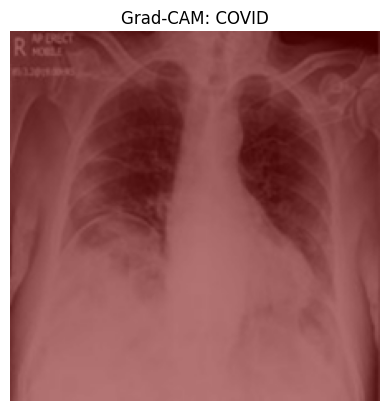

In [7]:
def gradcam_visualize(model, img_array, label_index, layer_name="top_conv", alpha=0.5):
    if img_array.ndim == 3:
        img_array = np.expand_dims(img_array, axis=0)
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, label_index]
    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(conv_outputs[0], weights), axis=-1).numpy()
    cam = np.maximum(cam, 0)
    if np.max(cam) != 0 and cam.size > 0:
        cam = cam / np.max(cam)
    else:
        cam = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)  # fallback for invalid cam

    cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    original = (img_array[0] * 255).astype(np.uint8)
    superimposed = cv2.addWeighted(original, 1 - alpha, heatmap, alpha, 0)
    return superimposed, heatmap

for class_label in le.classes_:
    class_index = le.transform([class_label])[0]
    idx = np.where(y_test == class_index)[0][0]
    img = X_test[idx]
    result, heatmap = gradcam_visualize(final_model, img, class_index)
    plt.imshow(result)
    plt.title(f"Grad-CAM: {class_label}")
    plt.axis('off')
    plt.colorbar(plt.cm.ScalarMappable(cmap='jet'), label='Focus Intensity')
    plt.savefig(f"{RESULTS_DIR}/gradcam_{class_label.lower()}.png")
    plt.show()


In [ ]:
# =============================================================
# 🧪 Final Evaluation
# =============================================================

21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

2025-09-18 22:41:32.598029: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k2=0,k4=2,k5=3,k6=3,k7=2} for conv (f16[20,112,112,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[20,225,225,4]{3,2,1,0}, f16[64,3,3,4]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-09-18 22:41:32.598063: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k2=4,k4=1,k5=4,k6=3,k7=2} for conv (f16[20,112,112,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[20,225,225,4]{3,2,1,0}, f16[64,3,3,4]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="_

23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 987ms/step


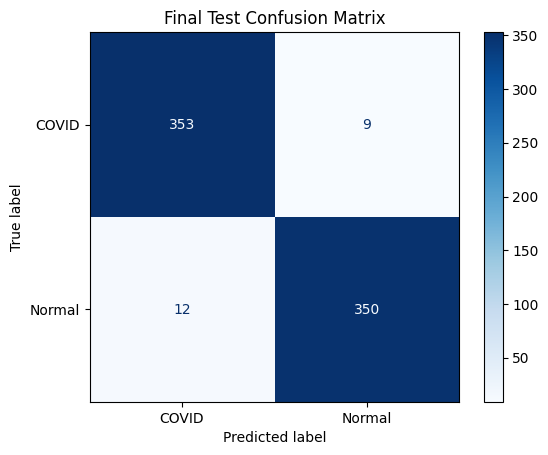

In [8]:
test_preds = final_model.predict(X_test)
y_test_pred = np.argmax(test_preds, axis=1)
cm = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot(cmap=plt.cm.Blues)
plt.title("Final Test Confusion Matrix")
plt.savefig(f"{RESULTS_DIR}/final_test_confusion_matrix.png")
plt.show()

In [ ]:
# =============================================================
# 📊 Final Metrics Summary (Train vs Test)
# =============================================================

In [ ]:
train_preds = final_model.predict(X_temp)
train_labels = np.argmax(y_temp_cat, axis=1)
train_pred_labels = np.argmax(train_preds, axis=1)
test_pred_labels = np.argmax(test_preds, axis=1)

final_metrics = {
    "Dataset": ["Training", "Testing"],
    "Accuracy": [
        accuracy_score(train_labels, train_pred_labels),
        accuracy_score(y_test, test_pred_labels)
    ],
    "Precision": [
        precision_score(train_labels, train_pred_labels, average="macro"),
        precision_score(y_test, test_pred_labels, average="macro")
    ],
    "Recall": [
        recall_score(train_labels, train_pred_labels, average="macro"),
        recall_score(y_test, test_pred_labels, average="macro")
    ],
    "F1-score": [
        f1_score(train_labels, train_pred_labels, average="macro"),
        f1_score(y_test, test_pred_labels, average="macro")
    ]
}

df_final = pd.DataFrame(final_metrics)
print("\n=== Final Training vs Testing Metrics ===")
print(df_final.to_string(index=False))

# Accuracy & Loss Plots
train_loss = final_model.evaluate(X_temp, y_temp_cat, verbose=0)[0]
test_loss = final_model.evaluate(X_test, tf.keras.utils.to_categorical(y_test, NUM_CLASSES), verbose=0)[0]

plt.figure()
plt.bar(["Train", "Test"], [train_loss, test_loss])
plt.title("Loss Comparison")
plt.ylabel("Loss")
plt.savefig(f"{RESULTS_DIR}/train_vs_test_loss.png")
plt.close()

plt.figure()
plt.bar(["Train", "Test"], df_final["Accuracy"])
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy")
plt.savefig(f"{RESULTS_DIR}/train_vs_test_accuracy.png")
plt.close()

204/204 ━━━━━━━━━━━━━━━━━━━━ 21s 101ms/step

=== Final Training vs Testing Metrics ===
 Dataset  Accuracy  Precision   Recall  F1-score
Training  0.993700   0.993706 0.993700  0.993700
 Testing  0.970994   0.971027 0.970994  0.970994
